In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as Variable

import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

In [103]:
from sklearn import datasets
X_np, y_np = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

Allows loading both real and synthetic datasets.


→ Synthetic datasets can be generated with functions like make_classification, among others.


→ Real datasets can be loaded with functions such as load_iris.

In [104]:
X = torch.from_numpy(X_np).float()

The .float() is used to convert the tensor to torch.float32, because after conversion it is in float64.

In [105]:
y=torch.from_numpy(y_np).float()
y = y.unsqueeze(1)

In [106]:
print(X.size())
print(y.size())

torch.Size([1000, 2])
torch.Size([1000, 1])


In [107]:
print(X.mean(dim=0))
print(X.std(dim=0))

tensor([ 0.0039, -0.0052])
tensor([0.6034, 0.5820])


For an MLP, the input features should be centered and scaled, so we apply normalization to the dataset.

In [108]:
X -= X.mean(dim=0)
X /= X.std(dim=0)

X

tensor([[-0.1123,  1.9392],
        [-0.1637,  0.4511],
        [ 0.1275,  1.1189],
        ...,
        [ 1.4665, -0.9355],
        [-1.0199,  0.1902],
        [ 0.0184,  0.9316]])

In [109]:
n_in = X.shape[1]
n_h1 = 20
n_h2 = 10
n_out = 1

nb_epoch = 10000
alpha = 0.1


In [110]:
W1 = torch.randn(n_in, n_h1, requires_grad=True)
W1.data *= 0.01

b1 = torch.zeros(1, n_h1, requires_grad=True)

W2 = torch.randn(n_h1, n_h2, requires_grad=True)
W2.data *= 0.01

b2 = torch.zeros(1, n_h2, requires_grad=True)

W3 = torch.randn(n_h2, n_out, requires_grad=True)
W3.data *= 0.01

b3 = torch.zeros(1, n_out, requires_grad=True)


In [111]:
def model(X):
  A0 = X
  Z1 = torch.mm(A0, W1) + b1
  A1 = F.relu(Z1)
  Z2 = torch.mm(A1, W2) + b2
  A2 = F.relu(Z2)
  Z3 = torch.mm(A2, W3) + b3
  A3 = torch.sigmoid(Z3)
  hat_y = A3
  return hat_y

In [112]:
for num_epoch in range(0, nb_epoch):
  hat_y = model(X)
  eps = 1e-10
  hat_y = torch.clamp(hat_y, eps, 1-eps)
  #We force hat_y to be never equals to 0 so the gradients remain stable.

  loss = -(y*torch.log(hat_y)+(1-y)*torch.log(1-hat_y))
  cost = loss.mean() #1/n * loss

  if num_epoch % 500 == 0:
    print('epoch {}, loss {}'.format(num_epoch, cost))

  cost.backward()

  with torch.no_grad():
      W1 -= W1.grad*alpha
      b1 -= b1.grad*alpha
      W2 -= W2.grad*alpha
      b2 -= b2.grad*alpha
      W3 -= W3.grad*alpha
      b3 -= b3.grad*alpha

  W1.grad.zero_()
  b1.grad.zero_()
  W2.grad.zero_()
  b2.grad.zero_()
  W3.grad.zero_()
  b3.grad.zero_()



epoch 0, loss 0.6931473612785339
epoch 500, loss 0.6931434869766235
epoch 1000, loss 0.6931400299072266
epoch 1500, loss 0.6931335926055908
epoch 2000, loss 0.6931191682815552
epoch 2500, loss 0.6930781602859497
epoch 3000, loss 0.6929047703742981
epoch 3500, loss 0.6910672187805176
epoch 4000, loss 0.38463497161865234
epoch 4500, loss 0.21853254735469818
epoch 5000, loss 0.216589093208313
epoch 5500, loss 0.2162771373987198
epoch 6000, loss 0.2159327119588852
epoch 6500, loss 0.21570822596549988
epoch 7000, loss 0.21558716893196106
epoch 7500, loss 0.21548336744308472
epoch 8000, loss 0.21541856229305267
epoch 8500, loss 0.21536895632743835
epoch 9000, loss 0.21532665193080902
epoch 9500, loss 0.21529226005077362


A weight must be a leaf tensor so that PyTorch actually stores its gradient during backpropagation.

We can use this to make our code up-to-date:

W = torch.nn.Parameter(torch.randn(3,3) * 0.01)

**Using nn.sequential**

In [113]:
my_model = nn.Sequential(
    nn.Linear(n_in, n_h1),
    nn.ReLU(),
    nn.Linear(n_h1,n_h2),
    nn.ReLU(),
    nn.Linear(n_h2,n_out),
    nn.Sigmoid()
)

In [114]:
criterion = nn.BCELoss()
optimizer = optim.SGD(my_model.parameters(), lr = alpha)

epoch 0, loss 0.6905264854431152
epoch 500, loss 0.23115333914756775
epoch 1000, loss 0.2186664491891861
epoch 1500, loss 0.21630877256393433
epoch 2000, loss 0.21502207219600677
epoch 2500, loss 0.2143062949180603
epoch 3000, loss 0.21388107538223267
epoch 3500, loss 0.21343562006950378
epoch 4000, loss 0.2129921168088913
epoch 4500, loss 0.2126321643590927
epoch 5000, loss 0.2122291773557663
epoch 5500, loss 0.2117411345243454
epoch 6000, loss 0.21119597554206848
epoch 6500, loss 0.21076498925685883
epoch 7000, loss 0.21041910350322723
epoch 7500, loss 0.20998533070087433
epoch 8000, loss 0.20963406562805176
epoch 8500, loss 0.20934662222862244
epoch 9000, loss 0.20897379517555237
epoch 9500, loss 0.20869049429893494


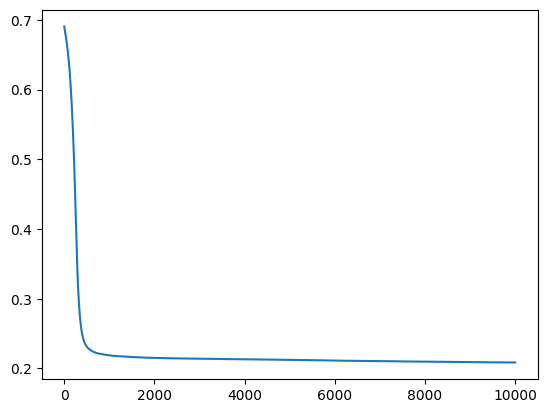

In [115]:
loss_l=[]
for num_epoch in range(nb_epoch):
  hat_y = my_model(X) # Forward pass: Compute predicted y by passing  x to the model
  loss =  criterion(hat_y, y)# Compute loss
  # Zero gradients, perform a backward pass, and update the weights.
  optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
  loss.backward()# perform back-propagation
  optimizer.step()# update the weights
  loss_l.append(loss.item())

  if num_epoch % 500 == 0:
    print('epoch {}, loss {}'.format(num_epoch, loss.item()))

plt.plot(loss_l)

In [123]:
class My_model(torch.nn.Module):
  def __init__(self,n_in,n_h1,n_h2,n_out):
    super(My_model, self). __init__()

    self.fc1 = nn.Linear(n_in, n_h1)
    self.fc2 = nn.Linear(n_h1, n_h2)
    self.fc3 = nn.Linear(n_h2, n_out)

  def forward(self, X):
    A0 = X
    Z1 = self.fc1(A0)
    A1 = F.relu(Z1)  # activation function for hidden layer 1
    Z2 = self.fc2(A1)
    A2 = F.relu(Z2)  # activation function for hidden layer 2
    Z3 = self.fc3(A2)
    A3 = torch.sigmoid(Z3)   # activation function for output layer

    return A3

model_class = My_model(n_in, n_h1, n_h2, n_out)

In [124]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model_class.parameters(),lr=alpha)

epoch 0, loss 0.6944544315338135
epoch 500, loss 0.22531485557556152
epoch 1000, loss 0.21777985990047455
epoch 1500, loss 0.21628031134605408
epoch 2000, loss 0.21582205593585968
epoch 2500, loss 0.21520596742630005
epoch 3000, loss 0.21484878659248352
epoch 3500, loss 0.2143867015838623
epoch 4000, loss 0.21419194340705872
epoch 4500, loss 0.21402810513973236
epoch 5000, loss 0.21385997533798218
epoch 5500, loss 0.21369537711143494
epoch 6000, loss 0.21352854371070862
epoch 6500, loss 0.2133513242006302
epoch 7000, loss 0.21320736408233643
epoch 7500, loss 0.21308106184005737
epoch 8000, loss 0.21296200156211853
epoch 8500, loss 0.21284018456935883
epoch 9000, loss 0.21271584928035736
epoch 9500, loss 0.2126132696866989


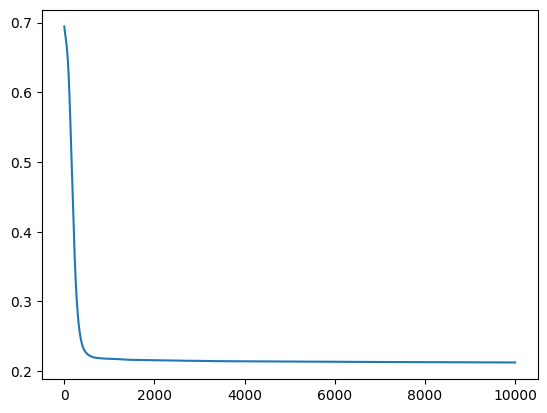

In [125]:
loss_l = []
for num_epoch in range(nb_epoch):
  hat_y = model_class(X) # Forward pass: Compute predicted y by passing  x to the model
  loss =  criterion(hat_y, y)# Compute loss
  # Zero gradients, perform a backward pass, and update the weights.
  optimizer.zero_grad() # re-init the gradients (otherwise they are cumulated)
  loss.backward()# perform back-propagation
  optimizer.step()# update the weights


  loss_l.append(loss.item())

  if num_epoch % 500 == 0:
    print('epoch {}, loss {}'.format(num_epoch, loss.item()))

plt.plot(loss_l);